## State Reducers

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph

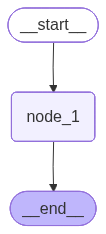

In [2]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    my_int: int
    
def node_1(state):
    print("=== NODE 1 ===")
    return {"my_int": state['my_int'] + 1}


builder = StateGraph(State)
builder.add_node("node_1", node_1)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
graph.invoke({"my_int": 1})

=== NODE 1 ===


{'my_int': 2}

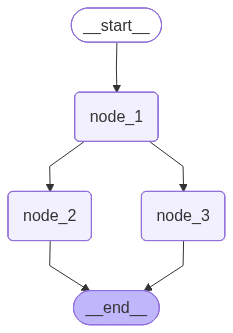

In [4]:
class State(TypedDict):
    my_int: int
    
def node_1(state):
    print("=== NODE 1 ===")
    return {"my_int": state["my_int"] + 1}

def node_2(state):
    print("=== NODE 2 ===")
    return {"my_int": state["my_int"] + 1}

def node_3(state):
    print("=== NODE 3 ===")
    return {"my_int": state["my_int"] + 1}

builder = StateGraph(State)

builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
graph.invoke({"my_int": 1})

=== NODE 1 ===
=== NODE 2 ===
=== NODE 3 ===


InvalidUpdateError: At key 'my_int': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://docs.langchain.com/oss/python/langgraph/errors/INVALID_CONCURRENT_GRAPH_UPDATE

## Reducer

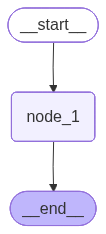

In [6]:
from operator import add
from typing import Annotated


class State(TypedDict):
    my_int: Annotated[list[int], add]
    
def node_1(state):
    print("---Node 1---")
    return {"my_int": [state['my_int'][0] + 1]}


builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

graph = builder.compile()


display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
graph.invoke({"my_int" : [1]})
# not overwriting, rather, i am appending a new value to this list

---Node 1---


{'my_int': [1, 2]}

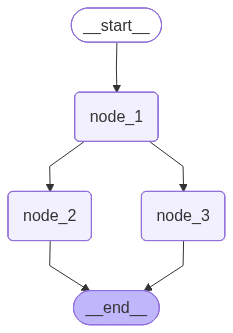

In [8]:
def node_1(state):
    print("=== NODE 1 ===")
    return {"my_int": [state["my_int"][-1] + 1]}

def node_2(state):
    print("=== NODE 2 ===")
    return {"my_int": [state["my_int"][-1] + 1]}

def node_3(state):
    print("=== NODE 3 ===")
    return {"my_int": [state["my_int"][-1] + 1]}

builder = StateGraph(State)

builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
graph.invoke({"my_int" : [1]})
# not overwriting, rather, i am appending a new value to this list

=== NODE 1 ===
=== NODE 2 ===
=== NODE 3 ===


{'my_int': [1, 2, 3, 3]}

In [10]:
try:
    graph.invoke({"my_int" : None})
except TypeError as e:
    print(f"TypeError occurred: {e}")

TypeError occurred: can only concatenate list (not "NoneType") to list


## Messages

In [ ]:
from typing import Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class CustomMessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    # arbitrary_keys
    added_key_1: str
    added_key_2: str
    
class ExtendedMessagesState(MessagesState):
    # equivalent to: messages: Annotated[list[AnyMessage], add_messages]
    
    added_key_1: str
    added_key_2: str

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph.message import add_messages

initial_messages = [
    AIMessage(content = "Hi, how can i assist you?", name = "Model"),
    HumanMessage(content = "I need your assistance with writing an email to my school princiapl", name = "Shiv")
]

new_message = AIMessage(content = "Sure, I can help with that. What is the topic about?", name = "Model")

add_messages(initial_messages, new_message)

# Appending

## Overwriting

In [11]:
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph.message import add_messages

initial_messages = [
    AIMessage(content = "Hi, how can i assist you?", name = "Model", id = 1),
    HumanMessage(content = "I need your assistance with writing an email to my school princiapl", name = "Shiv", id = 2)
]

new_message = AIMessage(content = "I need help on writing about importance of education", name = "Shiv", id = 1)

add_messages(initial_messages, new_message)

# Overwriting

[AIMessage(content='I need help on writing about importance of education', additional_kwargs={}, response_metadata={}, name='Shiv', id='1', tool_calls=[], invalid_tool_calls=[]),
 HumanMessage(content='I need your assistance with writing an email to my school princiapl', additional_kwargs={}, response_metadata={}, name='Shiv', id='2')]

## Removal

In [12]:
from langchain_core.messages import RemoveMessage

# Message list
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Shiv", id="2"))
messages.append(AIMessage("So you said you want to write an email?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I want to write an email on how to win a Gold medal for studies", name="Shiv", id="4"))
messages.append(AIMessage("Awesome drive, that's's great motivation", name="Bot", id="5"))
messages.append(HumanMessage("Thank you, please make it formal and concise.", name="Shiv", id="6"))

# Isolate messages to delete; remove all but the 2 most recent messages
delete_messages = [RemoveMessage(id = m.id) for m in messages[:-2]]
print(delete_messages)

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='3'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='4')]


In [14]:
add_messages(messages , delete_messages)

[AIMessage(content="Awesome drive, that's's great motivation", additional_kwargs={}, response_metadata={}, name='Bot', id='5', tool_calls=[], invalid_tool_calls=[]),
 HumanMessage(content='Thank you, please make it formal and concise.', additional_kwargs={}, response_metadata={}, name='Shiv', id='6')]